# Sensores Phybox

## Datos adquiridos

Para la realización del ejercicio se recogen datos de:
* Subir escaleras
* Bajar escaleras
* Caminar
* Correr
* Estar quieto en el metro

Conocemos que, poniendo el móvil sobre la mesa:
* El eje x es el que va de izquierda a derecha
* El eje y es el que va de delante a detrás
* El eje z es el que va de arriba a abajo
* Además, el acelerómetro mide la aceleración en m/s^2

In [48]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from sklearn.decomposition import PCA
from scipy.signal import get_window

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [30]:
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

### 1. Carga de datos

In [31]:
# Solo aceleración en los tres ejes, absoluta no
def carga_df(filename, etiqueta):
    df = pd.read_csv(os.path.join('data', filename)).iloc[:, :4]
    df['etiqueta'] = etiqueta
    df.columns = ['time', 'x', 'y', 'z', 'etiqueta']
    return df

In [32]:
df_bajar1 = carga_df('bajar_escaleras_1.csv', 'bajar_escaleras')
df_bajar2 = carga_df('bajar_escaleras_2.csv', 'bajar_escaleras')
df_subir = carga_df('subir_escaleras.csv', 'subir_escaleras')
df_metro = carga_df('enelmetro.csv', 'metro')

In [50]:
df_bajar1.shape

(5638, 5)

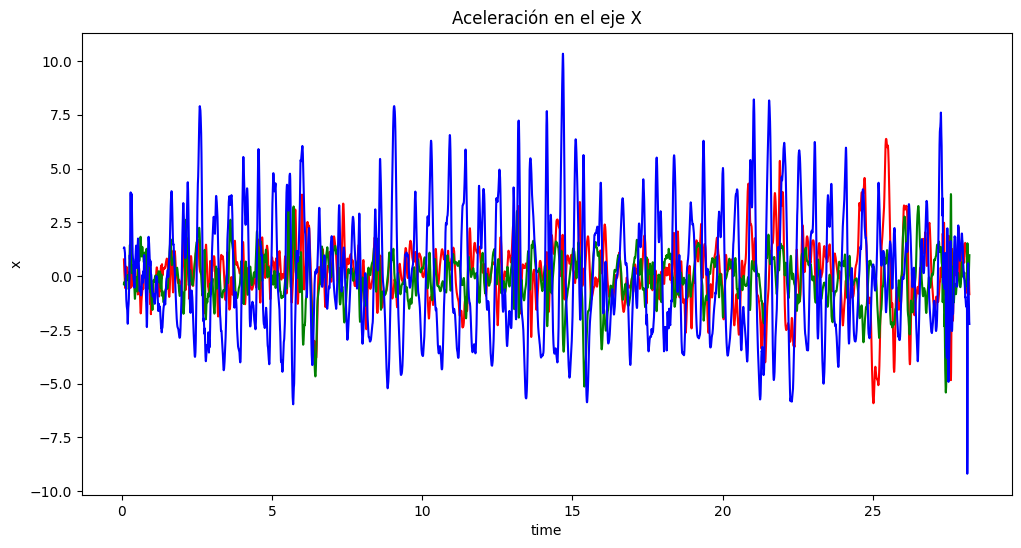

In [43]:
# Visualizar los datos
setup_graph(title='Aceleración en el eje X', x_label='time', y_label='x', fig_size=(12, 6))
plt.plot(df_bajar1['time'], df_bajar1['x'], color='r')
plt.plot(df_bajar1['time'], df_bajar1['y'], color='g')
plt.plot(df_bajar1['time'], df_bajar1['z'], color='b')
plt.show()

In [34]:
# Recreación del movimiento en 3D


## Metodología

### 2. Obtener características con una ventana móvil que se va solapando

In [ ]:
# Cada ventana tendrá 1000 puntos, y el dataframe para clasificar contendrá una fila por ventana y una columna por característica extraída, además de la etiqueta

#### - Dominio del tiempo

In [62]:
# Dominio del tiempo: max, min, std, kurtosis...
def freq_features(raw_df, window_size=1000, step_size=200):
    data = []
    for i in range(0, len(raw_df)-window_size, step_size):
        df = raw_df[i:i+window_size]
        data.append([df['x'].max(), df['x'].min(), df['x'].std(), df['x'].kurtosis(),
                     df['y'].max(), df['y'].min(), df['y'].std(), df['y'].kurtosis(),
                     df['z'].max(), df['z'].min(), df['z'].std(), df['z'].kurtosis(), df['etiqueta'].iloc[0]])
    
    return pd.DataFrame(data, columns=['x_max', 'x_min', 'x_std', 'x_kurtosis',
                                        'y_max', 'y_min', 'y_std', 'y_kurtosis',
                                        'z_max', 'z_min', 'z_std', 'z_kurtosis', 'etiqueta'])

In [55]:
(5600-1000)/200 # (n_puntos-ventana_size)/step_size = n_ventanas

23.0

In [65]:
df_bajar1_features = freq_features(df_bajar1)
df_bajar2_features = freq_features(df_bajar2)
df_subir_features = freq_features(df_subir)
df_metro_features = freq_features(df_metro)

# Concatenar los dataframes
df_caracts_tiempo_1 = pd.concat([df_bajar1_features, df_bajar2_features, df_subir_features, df_metro_features], ignore_index=True)

#### - Dominio de la frecuencia

In [36]:
# Dominio de la frecuencia (puede que se obtengan mejores resultados) --> MyFFT y de la transformada saco las características
def myFTT(Fs, X):
    window = get_window('hann', len(X), fftbins=True)
    X = X * window
    fft_out = np.fft.rfft(X)
    fft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(fft_out) for i in fft_out]
    num_samples = len(X)
    rfreqs = [(i*1.0/num_samples)*Fs for i in range(num_samples//2+1)]
    return rfreqs, fft_mag

### 3. Clasificador 1: RF, xgboost, SVM, catboost

In [66]:
catboost = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass')
X = df_caracts_tiempo_1.iloc[:, :-1]
y = df_caracts_tiempo_1['etiqueta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
accuracy_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

0:	learn: 1.0499970	total: 170ms	remaining: 2m 49s
1:	learn: 1.0091876	total: 173ms	remaining: 1m 26s
2:	learn: 0.9324063	total: 175ms	remaining: 58.1s
3:	learn: 0.8836722	total: 177ms	remaining: 44.1s
4:	learn: 0.8317218	total: 181ms	remaining: 35.9s
5:	learn: 0.7821508	total: 183ms	remaining: 30.4s
6:	learn: 0.7479407	total: 187ms	remaining: 26.6s
7:	learn: 0.7139859	total: 190ms	remaining: 23.6s
8:	learn: 0.6696043	total: 193ms	remaining: 21.2s
9:	learn: 0.6461929	total: 195ms	remaining: 19.3s
10:	learn: 0.6152263	total: 198ms	remaining: 17.8s
11:	learn: 0.5943064	total: 199ms	remaining: 16.4s
12:	learn: 0.5617910	total: 202ms	remaining: 15.4s
13:	learn: 0.5378660	total: 205ms	remaining: 14.4s
14:	learn: 0.5140367	total: 207ms	remaining: 13.6s
15:	learn: 0.4910762	total: 210ms	remaining: 12.9s
16:	learn: 0.4706082	total: 211ms	remaining: 12.2s
17:	learn: 0.4451429	total: 214ms	remaining: 11.7s
18:	learn: 0.4280292	total: 217ms	remaining: 11.2s
19:	learn: 0.4147830	total: 219ms	remai

array([[11,  0,  0],
       [ 0,  3,  0],
       [ 0,  0,  1]], dtype=int64)

### 4. Fourier

In [37]:
# Kurtosis espectral
# Frecuencia dominante
# Potencia espectral total: sumatorio de magnitudes obtenidas con Fourier en cada ventana de las definidas

### 5. Clasificador 2 con las nuevas características (mantener mismos modelos para poder comparar resultados)

## Resultados

### 6. La más importante, comparar resultados, explicar modelos creados e interpretar características en ambos dominios

Presentación: 2 mins cada apartado/persona, 5-10 total